In [ ]:
# Week 6 – Amazon Reviews 2023 Data Cleaning + Visualization
# Environment: genai_data (py3.10) | datasets==2.14.6 | pyarrow==12.0.1 | numpy<2

import os, sys, multiprocessing, warnings, pandas as pd
warnings.filterwarnings("ignore")

print("✅ Python:", sys.version.split()[0])
print("🧠 CPU Cores Available:", multiprocessing.cpu_count())

# Create folders
os.makedirs("../data/cleaned", exist_ok=True)
print("📂 Folder ready → data/cleaned (raw data cached by Hugging Face automatically)")


✅ Python: 3.10.19
🧠 CPU Cores Available: 64
📂 Folder ready → data/cleaned (raw data cached by Hugging Face automatically)


In [3]:
!pip install -q "numpy<2.0.0" "datasets==2.14.6" "pyarrow==12.0.1" pandas matplotlib seaborn tqdm

from datasets import get_dataset_config_names, load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from glob import glob

plt.style.use("seaborn-v0_8")
sns.set_theme(context="talk", style="whitegrid", palette="crest")


In [7]:
DATASET_ID = "McAuley-Lab/Amazon-Reviews-2023"
CLEAN_DIR = "data/cleaned"
MIN_PRICE, MAX_PRICE = 0.5, 999.49
MAX_WORKERS = 8   # ✅ optimal for I/O heavy workloads

print(f"🧭 Dataset → {DATASET_ID}")
print(f"⚙️ Using {MAX_WORKERS} CPU workers")

cols_to_keep = [
    "main_category",
    "title",
    "features",
    "description",
    "average_rating",
    "rating_number",
    "store",
    "category",
    "price_num"
]



🧭 Dataset → McAuley-Lab/Amazon-Reviews-2023
⚙️ Using 8 CPU workers


In [5]:
def safe_float(x):
    try:
        return float(x)
    except Exception:
        return None


def clean_subset(subset_name: str):
    """Clean one subset and save as Parquet + CSV."""
    try:
        ds = load_dataset(DATASET_ID, subset_name, split="full")  # ✅ no trust_remote_code
        df = pd.DataFrame(ds)
        df["category"] = subset_name.replace("raw_meta_", "")
        df["price_num"] = pd.to_numeric(df["price"], errors="coerce")

        # Apply filters
        df = df.dropna(subset=["price_num"])
        df = df[(df["price_num"] >= MIN_PRICE) & (df["price_num"] <= MAX_PRICE)]
        df = df[df["title"].astype(str).str.strip() != ""]
        df = df[df["description"].apply(lambda x: isinstance(x, list) and len(x) > 0)]

        # Save to both formats
        base = os.path.join(CLEAN_DIR, subset_name.replace("raw_meta_", ""))
        df.to_parquet(base + "_clean.parquet", index=False)
        df.to_csv(base + "_clean.csv", index=False)

        return subset_name, len(df)
    except Exception as e:
        return subset_name, f"Error: {e}"


In [5]:
print(f"📦 Fetching subset names for {DATASET_ID} …")
subsets = get_dataset_config_names(DATASET_ID)
meta_subsets = [s for s in subsets if s.startswith("raw_meta_")]
print(f"Found {len(meta_subsets)} metadata subsets.\n")

results = []
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = [ex.submit(clean_subset, s) for s in meta_subsets]
    for f in tqdm(as_completed(futures), total=len(futures), desc="🧹 Cleaning Subsets"):
        results.append(f.result())

print("\n🧾 Cleaning Summary:")
for subset, res in results:
    print(f"  • {subset}: {res}")


📦 Fetching subset names for McAuley-Lab/Amazon-Reviews-2023 …
Found 34 metadata subsets.



Generating full split: 0 examples [00:00, ? examples/s]2, 21.53s/it]
🧹 Cleaning Subsets: 100%|██████████| 34/34 [27:59<00:00, 49.39s/it] 



🧾 Cleaning Summary:
  • raw_meta_Gift_Cards: 286
  • raw_meta_All_Beauty: 7114
  • raw_meta_Handmade_Products: 82506
  • raw_meta_Musical_Instruments: 62923
  • raw_meta_Baby_Products: 33842
  • raw_meta_Digital_Music: 17104
  • raw_meta_Industrial_and_Scientific: 163248
  • raw_meta_Arts_Crafts_and_Sewing: 276547
  • raw_meta_Toys_and_Games: 303420
  • raw_meta_Subscription_Boxes: 0
  • raw_meta_Office_Products: 183637
  • raw_meta_Grocery_and_Gourmet_Food: 143032
  • raw_meta_Health_and_Household: 195877
  • raw_meta_Video_Games: 44258
  • raw_meta_Cell_Phones_and_Accessories: 148181
  • raw_meta_Pet_Supplies: 100404
  • raw_meta_Electronics: 340793
  • raw_meta_Unknown: 12704
  • raw_meta_Sports_and_Outdoors: 324796
  • raw_meta_Patio_Lawn_and_Garden: 240182
  • raw_meta_Tools_and_Home_Improvement: 420409
  • raw_meta_CDs_and_Vinyl: 363395
  • raw_meta_Magazine_Subscriptions: 0
  • raw_meta_Software: 15743
  • raw_meta_Health_and_Personal_Care: 6320
  • raw_meta_Appliances: 31778
 

In [6]:
import pyarrow.parquet as pq
import os
from glob import glob

# Path to all cleaned parquet files
parquet_files = sorted(glob(os.path.join("data/cleaned", "*_clean.parquet")))

columns_dict = {}

print(f"📦 Inspecting {len(parquet_files)} cleaned subsets...\n")

for file_path in parquet_files:
    try:
        table = pq.read_table(file_path)
        columns = table.column_names
        columns_dict[os.path.basename(file_path)] = columns
        print(f"✅ {os.path.basename(file_path)} → {len(columns)} columns")
    except Exception as e:
        print(f"⚠️ {os.path.basename(file_path)} → {e}")

print("\n📊 Summary:")
print(f"Total files scanned: {len(columns_dict)}")

# Save the dictionary to a JSON for later inspection
import json
with open("data/cleaned/columns_summary.json", "w") as f:
    json.dump(columns_dict, f, indent=2)

print("\n💾 Columns summary saved → data/cleaned/columns_summary.json")


📦 Inspecting 33 cleaned subsets...

✅ All_Beauty_clean.parquet → 18 columns
✅ Amazon_Fashion_clean.parquet → 18 columns
✅ Appliances_clean.parquet → 18 columns
✅ Arts_Crafts_and_Sewing_clean.parquet → 18 columns
✅ Automotive_clean.parquet → 18 columns
✅ Baby_Products_clean.parquet → 18 columns
✅ Beauty_and_Personal_Care_clean.parquet → 18 columns
⚠️ Books_clean.parquet → Nested data conversions not implemented for chunked array outputs
✅ CDs_and_Vinyl_clean.parquet → 18 columns
✅ Cell_Phones_and_Accessories_clean.parquet → 18 columns
✅ Clothing_Shoes_and_Jewelry_clean.parquet → 18 columns
✅ Digital_Music_clean.parquet → 18 columns
✅ Electronics_clean.parquet → 18 columns
✅ Gift_Cards_clean.parquet → 18 columns
✅ Grocery_and_Gourmet_Food_clean.parquet → 18 columns
✅ Handmade_Products_clean.parquet → 18 columns
✅ Health_and_Household_clean.parquet → 18 columns
✅ Health_and_Personal_Care_clean.parquet → 18 columns
✅ Home_and_Kitchen_clean.parquet → 18 columns
✅ Industrial_and_Scientific_c

In [13]:
parquet_files = sorted(glob(os.path.join(CLEAN_DIR, "*_clean.parquet")))
print(f"📦 Merging {len(parquet_files)} cleaned subsets with selected columns ...")

tables = []
for path in parquet_files:
    try:
        schema = pq.read_schema(path)
        cols_in_file = [c for c in cols_to_keep if c in schema.names]
        if not cols_in_file:
            print(f"⚠️ Skipping {os.path.basename(path)} → No matching columns")
            continue

        # Read table
        t = pq.read_table(path, columns=cols_in_file)

        # Harmonize data types to avoid merge conflict
        for name in t.schema.names:
            if name in ["price_num", "average_rating", "rating_number"]:
                # Always cast numeric fields to float64
                t = t.set_column(t.schema.get_field_index(name),
                                 name,
                                 pa.compute.cast(t[name], pa.float64()))
        tables.append(t)

    except Exception as e:
        print(f"⚠️ Skipping {os.path.basename(path)} → {e}")

# -----------------------------
# 🧮 Step 2 – Combine Tables Safely
# -----------------------------
if tables:
    combined = pa.concat_tables(tables, promote=True)
    print(f"✅ Combined Arrow table: {combined.num_rows:,} rows, {len(combined.column_names)} columns")
else:
    raise ValueError("❌ No tables were loaded successfully! Check your cleaned folder.")

# -----------------------------
# 💾 Step 3 – Save Master Parquet
# -----------------------------
final_parquet = os.path.join(CLEAN_DIR, "amazon_reviews_2023_selected.parquet")
pq.write_table(combined, final_parquet, compression="snappy")
print(f"💾 Saved master Parquet → {final_parquet}")

📦 Merging 33 cleaned subsets with selected columns ...
⚠️ Skipping Books_clean.parquet → Nested data conversions not implemented for chunked array outputs
⚠️ Skipping Magazine_Subscriptions_clean.parquet → No matching columns
⚠️ Skipping Subscription_Boxes_clean.parquet → No matching columns
✅ Combined Arrow table: 6,595,232 rows, 9 columns
💾 Saved master Parquet → data/cleaned/amazon_reviews_2023_selected.parquet


In [14]:
# Convert to Pandas for visualization (only lightweight columns)
df_all = combined.select([c for c in cols_to_keep if c != "description" and c != "features"]).to_pandas()
print(f"🧮 Final DataFrame shape: {df_all.shape}")

# Optional: Save lightweight CSV (for human inspection)
final_csv = os.path.join(CLEAN_DIR, "amazon_reviews_2023_selected.csv")
df_all.to_csv(final_csv, index=False)
print(f"💾 Saved CSV (light, no nested fields) → {final_csv}")


🧮 Final DataFrame shape: (6595232, 7)
💾 Saved CSV (light, no nested fields) → data/cleaned/amazon_reviews_2023_selected.csv


📊 Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
price_num,6595232.0,45.439604,84.118626,0.5,10.99,19.49,39.99,999.49
average_rating,6595223.0,4.256714,0.725955,1.0,4.00,4.40,4.70,5.00
rating_number,6594599.0,198.921044,1654.580667,1.0,4.00,17.00,69.00,726656.00



🏷️ Top 10 Categories by Count:


category
Clothing_Shoes_and_Jewelry    845227
Home_and_Kitchen              817930
Automotive                    803920
Tools_and_Home_Improvement    420409
Kindle_Store                  375539
CDs_and_Vinyl                 363395
Electronics                   340793
Sports_and_Outdoors           324796
Toys_and_Games                303420
Arts_Crafts_and_Sewing        276547
Name: count, dtype: int64

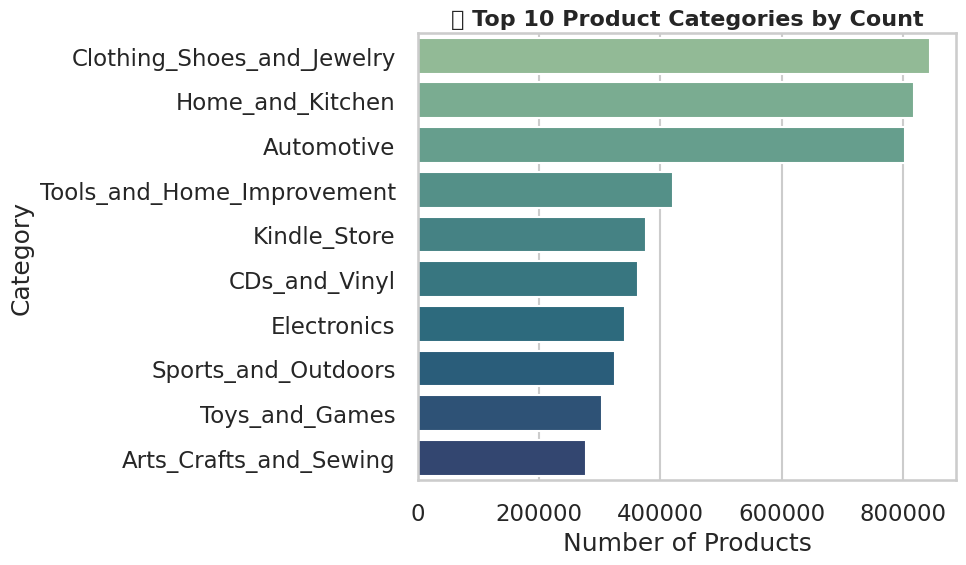

In [15]:
print("📊 Basic Statistics:")

# Only show stats for numeric columns if they exist
numeric_cols = [col for col in ["price_num", "average_rating", "rating_number"] if col in df_all.columns]
if numeric_cols:
    display(df_all[numeric_cols].describe().T)
else:
    print("⚠️ No numeric columns found for statistical summary.")

print("\n🏷️ Top 10 Categories by Count:")

if "category" in df_all.columns:
    top_categories = df_all["category"].value_counts().head(10)
    display(top_categories)

    # Optional barplot visualization for top categories
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories.values, y=top_categories.index, orient="h", palette="crest")
    plt.title("🏷️ Top 10 Product Categories by Count", fontsize=16, fontweight="bold")
    plt.xlabel("Number of Products")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Column 'category' not found in dataframe.")

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

# -----------------------------
# 🎨 Unified High-Contrast Style
# -----------------------------
sns.set_theme(context="talk", style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.edgecolor": "black",
    "axes.linewidth": 1.3,
    "grid.alpha": 0.25,
    "axes.labelweight": "bold",
    "axes.labelsize": 13,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "font.weight": "medium"
})

palette = sns.color_palette("coolwarm", as_cmap=False)

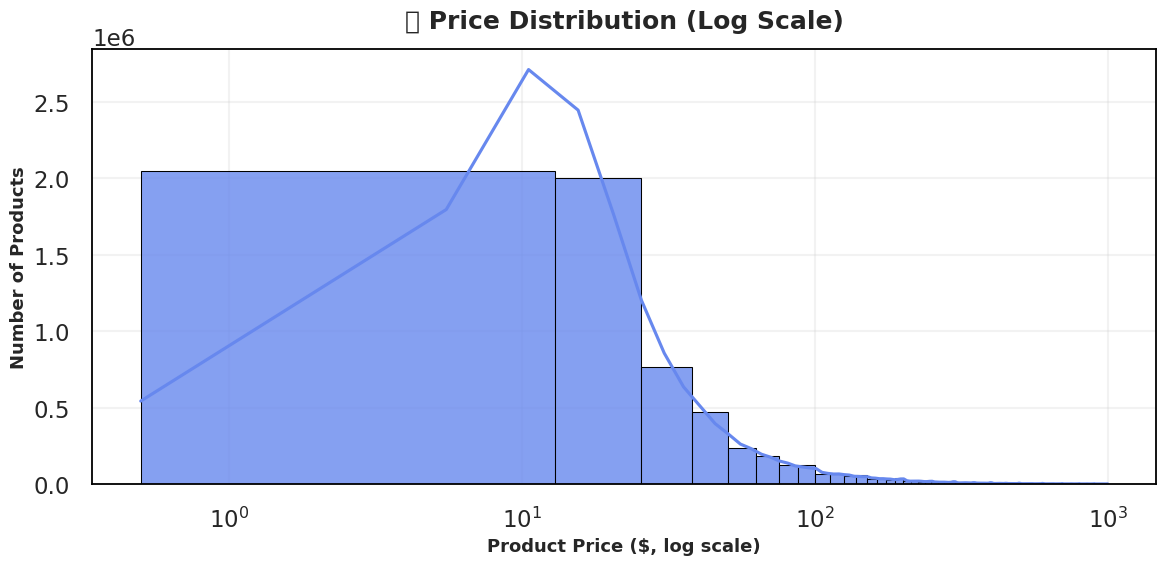

In [26]:
# -----------------------------
# 1️⃣ Price Distribution (Log Scale)
# -----------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df_all["price_num"], bins=80, kde=True, color=palette[0], edgecolor="black", alpha=0.8)
plt.xscale("log")
plt.title("💲 Price Distribution (Log Scale)", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Product Price ($, log scale)")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

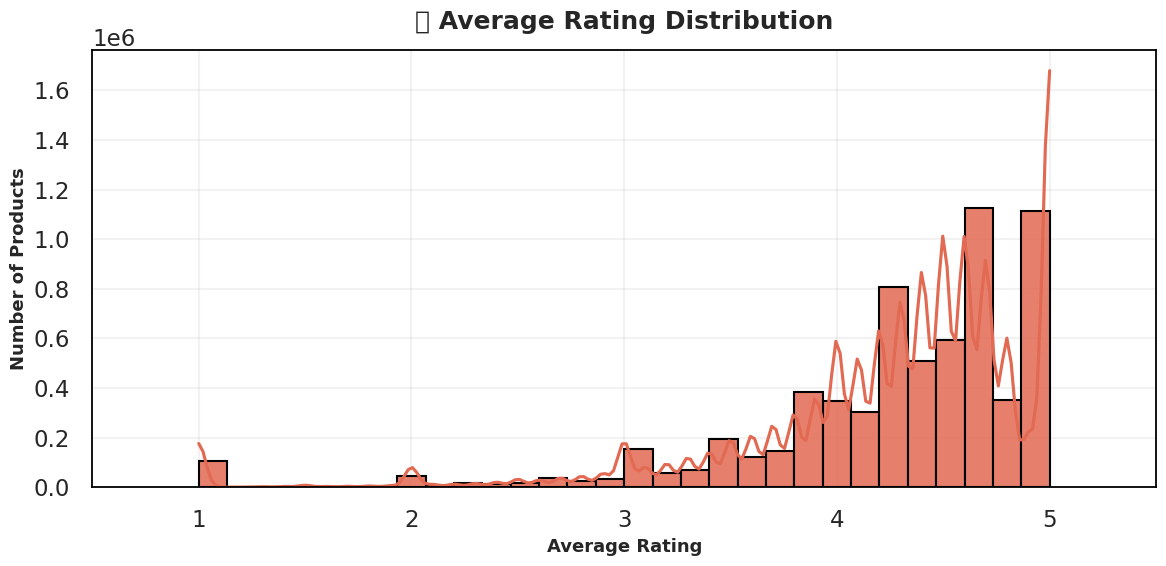

In [27]:
# -----------------------------
# 2️⃣ Average Rating Distribution
# -----------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df_all["average_rating"].dropna(), bins=30, kde=True, color=palette[-1], edgecolor="black", alpha=0.85)
plt.title("⭐ Average Rating Distribution", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Average Rating")
plt.ylabel("Number of Products")
plt.xlim(0.5, 5.5)
plt.tight_layout()
plt.show()

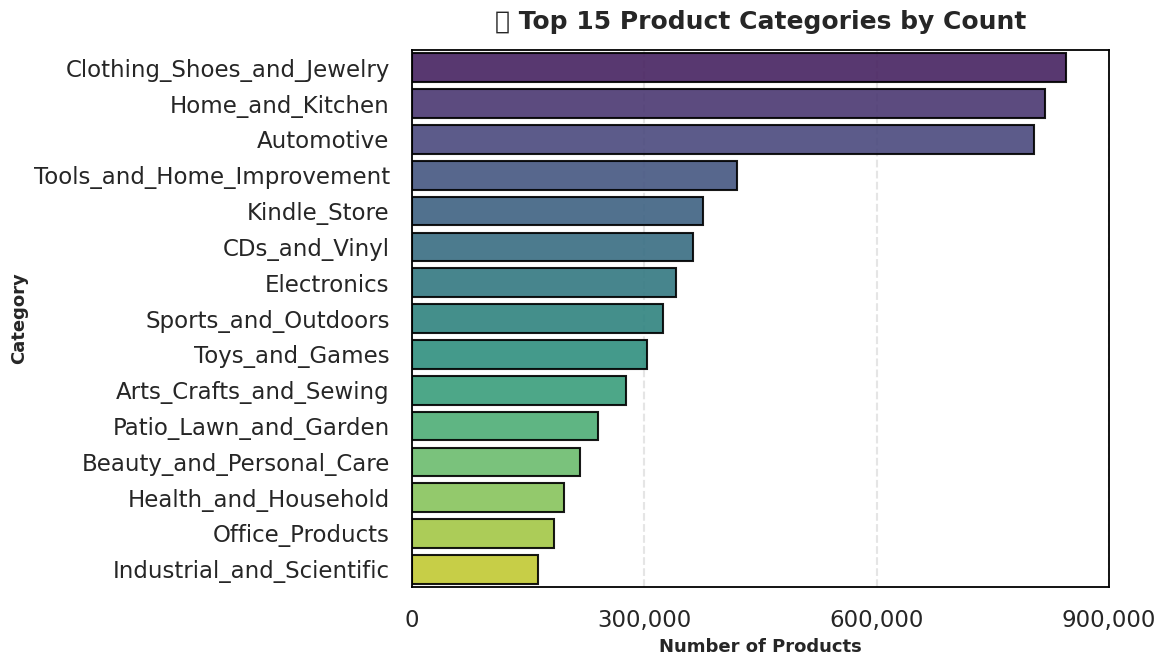

In [28]:
# -----------------------------
# 3️⃣ Top Categories by Count (Cleaned & Spaced)
# -----------------------------
if "category" in df_all.columns:
    top_cats = df_all["category"].value_counts().head(15)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis", edgecolor="black", alpha=0.9)
    plt.title("🏷️ Top 15 Product Categories by Count", fontsize=18, fontweight="bold", pad=15)
    plt.xlabel("Number of Products")
    plt.ylabel("Category")

    # 👉 Limit x-axis labels to only first, middle, last for clarity
    ax = plt.gca()
    ticks = ax.get_xticks()
    if len(ticks) > 3:
        spaced_ticks = [ticks[0], ticks[len(ticks)//3], ticks[2*len(ticks)//3], ticks[-1]]
        ax.set_xticks(spaced_ticks)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


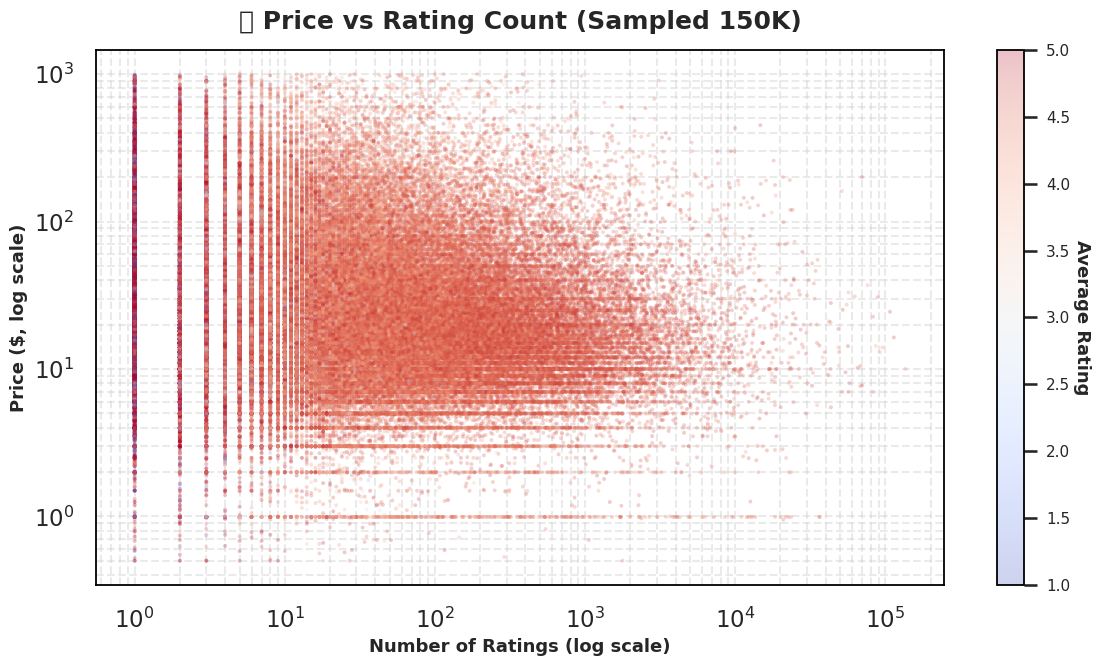

In [29]:
# -----------------------------
# 4️⃣ Sharpened Price vs Rating Count Scatter (No Blur)
# -----------------------------
if "rating_number" in df_all.columns and "price_num" in df_all.columns:
    sample = df_all.sample(n=min(150_000, len(df_all)), random_state=42)
    plt.figure(figsize=(12, 7))

    # Use smaller points & clear colormap to avoid blur
    scatter = plt.scatter(
        sample["rating_number"] + 1e-6,
        sample["price_num"] + 1e-6,
        alpha=0.25,
        s=8,
        c=sample["average_rating"] if "average_rating" in sample.columns else np.random.rand(len(sample)),
        cmap="coolwarm",
        linewidths=0.0
    )

    plt.xscale("log")
    plt.yscale("log")
    plt.title("📈 Price vs Rating Count (Sampled 150K)", fontsize=18, fontweight="bold", pad=15)
    plt.xlabel("Number of Ratings (log scale)")
    plt.ylabel("Price ($, log scale)")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)

    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Rating", rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=11)

    plt.tight_layout()
    plt.show()

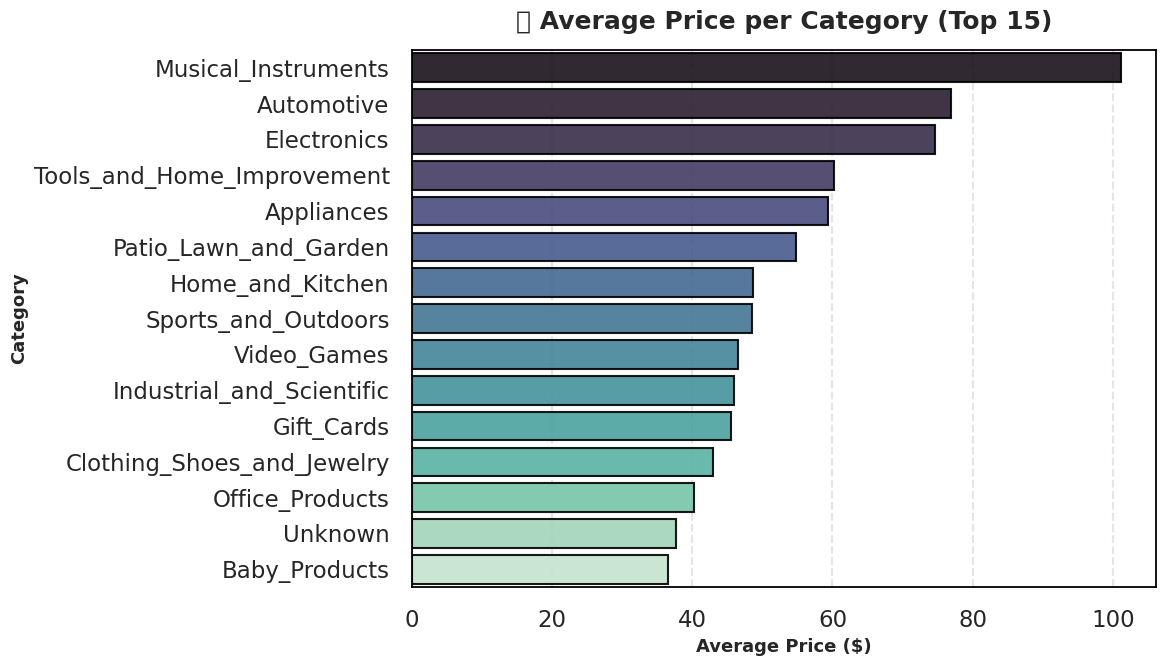

In [30]:
# -----------------------------
# 5️⃣ Average Price per Category (New Week 6 Analysis Plot)
# -----------------------------
if {"price_num", "category"} <= set(df_all.columns):
    avg_price = (
        df_all.groupby("category")["price_num"]
        .mean()
        .sort_values(ascending=False)
        .head(15)
    )

    plt.figure(figsize=(12, 7))
    sns.barplot(x=avg_price.values, y=avg_price.index, palette="mako", edgecolor="black", alpha=0.9)
    plt.title("💰 Average Price per Category (Top 15)", fontsize=18, fontweight="bold", pad=15)
    plt.xlabel("Average Price ($)")
    plt.ylabel("Category")
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

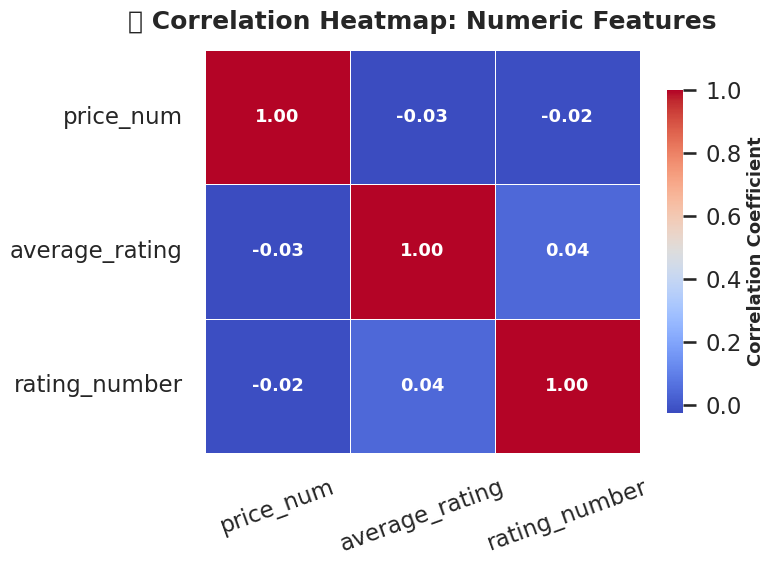

In [31]:
numeric_cols = ["price_num", "average_rating", "rating_number"]
existing_numeric = [c for c in numeric_cols if c in df_all.columns]

if len(existing_numeric) >= 2:
    corr = df_all[existing_numeric].corr(method="pearson")
    plt.figure(figsize=(8, 6))

    # Create heatmap with strong contrast and annotations
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.6,
        cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
        annot_kws={"size": 13, "weight": "bold"}
    )

    plt.title("🔗 Correlation Heatmap: Numeric Features", fontsize=18, fontweight="bold", pad=15)
    plt.xticks(rotation=20, ha="center")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough numeric columns found for correlation heatmap.")
